In [25]:
import tensorflow as tf
import cv2
import os
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K


In [26]:
# Prepare image function for resizing and cropping
def prep_image(image, crop_size, size_y, size_x):
    prepd_image = cv2.resize(image, (size_y, size_x))
    prepd_image = prepd_image[crop_size:-crop_size, crop_size:-crop_size]
    return prepd_image

# Define image dimensions and parameters
size_x = 148
size_y = 148
crop_size = 10

# Load and preprocess the images
train_images = []
for directory_path in glob.glob("Water Bodies Dataset/Images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = prep_image(img, crop_size, size_y, size_x)
        train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess the masks
train_masks = []
for directory_path in glob.glob("Water Bodies Dataset/Masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        mask = cv2.imread(mask_path, 0)
        mask = prep_image(mask, crop_size, size_y, size_x)
        train_masks.append(mask)
train_masks = np.array(train_masks)

In [27]:
# Normalize images and masks
x = train_images / 255
y = train_masks / 255

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
# Reshape y_train to have an additional channel dimension (1 for grayscale masks)
y_train = np.expand_dims(y_train, axis=-1)

# Data augmentation generator
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the image and mask data generators
image_datagen.fit(x_train)
mask_datagen.fit(y_train)

# Create the train image and mask generators
train_image_generator = image_datagen.flow(x_train, batch_size=32, seed=42)
train_mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

def combined_generator(image_gen, mask_gen):
    while True:
        x = next(image_gen)
        y = next(mask_gen)
        yield x, y

train_generator = combined_generator(train_image_generator, train_mask_generator)



In [29]:
# Define Dice loss function for better segmentation performance
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


In [30]:
# Define the U-Net model architecture
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    
    # Encoder (Downsampling)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder (Upsampling)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [31]:
# Debugging: check the shape and content of one batch from the generator
image_batch, mask_batch = next(train_generator)
print(image_batch.shape, mask_batch.shape)


(32, 128, 128, 3) (32, 128, 128, 1)


In [32]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=50,
    validation_data=(x_val, y_val),
    validation_steps=len(x_val) // 32,
    callbacks=[early_stop, model_checkpoint, lr_scheduler]
)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5697 - loss: 0.5924 - val_accuracy: 0.3628 - val_loss: 5.9886 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6615 - loss: 0.4380 - learning_rate: 0.0010
Epoch 3/50


D:\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
D:\anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
D:\anaconda\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
D:\anaconda\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6818 - loss: 0.4041 - val_accuracy: 0.3213 - val_loss: 5.2726 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6871 - loss: 0.3839 - learning_rate: 0.0010
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7001 - loss: 0.3538 - val_accuracy: 0.6046 - val_loss: 1.6364 - learning_rate: 0.0010
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 865ms/step - accuracy: 0.7031 - loss: 0.3417 - learning_rate: 0.0010
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 931ms/step - accuracy: 0.7111 - loss: 0.3389 - val_accuracy: 0.7370 - val_loss: 0.3836 - learning_rate: 0.0010
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 866ms/step - accuracy: 0.7170 - loss: 0.3137 - learning_rate: 0.0010
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 924ms/step - accuracy: 0.7104 - loss: 0.3184 - val_accuracy: 0.7622 - val_loss: 0.3118 - learning_rate: 0.0010
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 878ms/step - accuracy: 0.7249 -

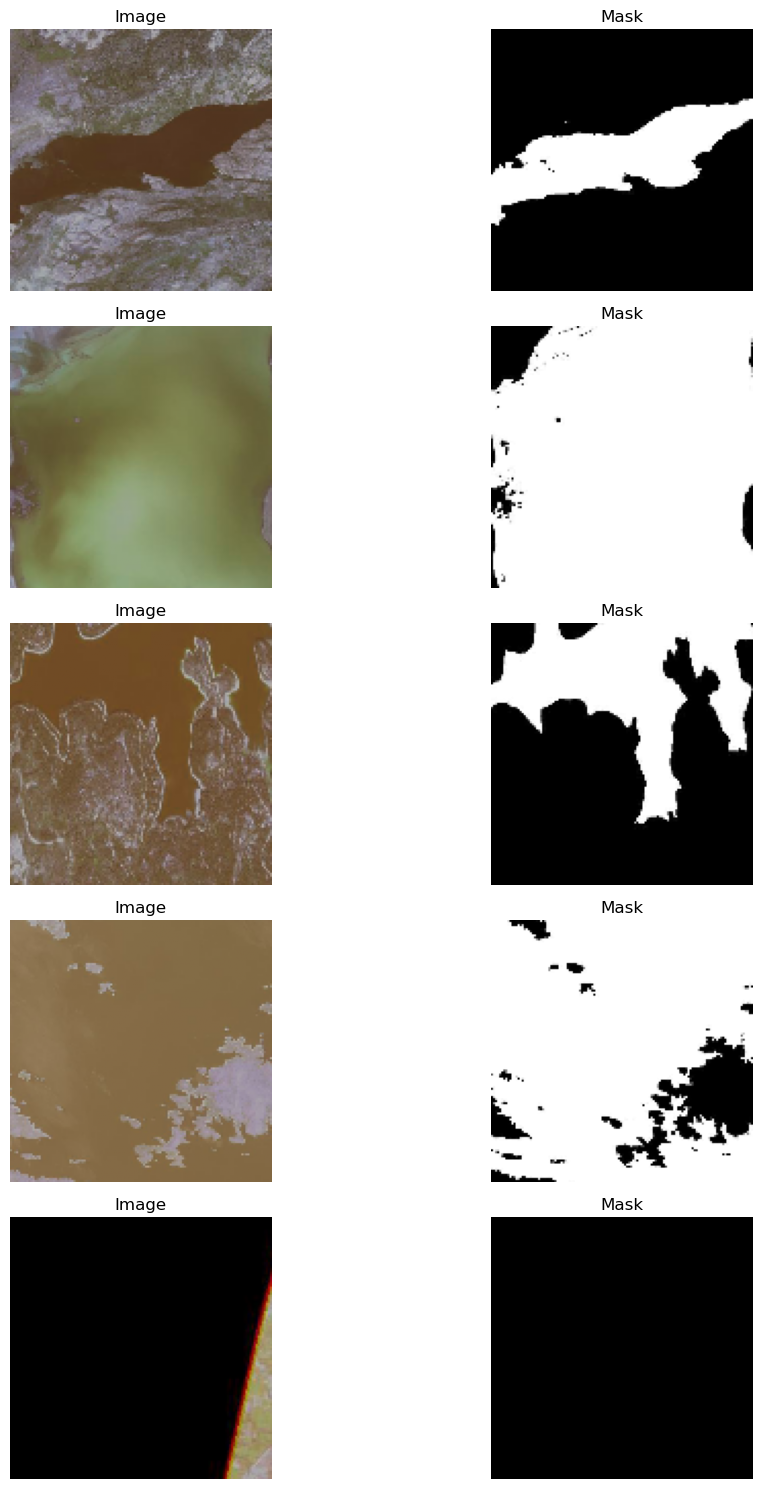

In [33]:
import matplotlib.pyplot as plt

# Plot a few random image-mask pairs
def visualize_samples(images, masks, num=5):
    plt.figure(figsize=(12, num * 3))
    for i in range(num):
        idx = np.random.randint(0, len(images))
        image = images[idx]
        mask = masks[idx]

        plt.subplot(num, 2, 2*i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(x_train, y_train)


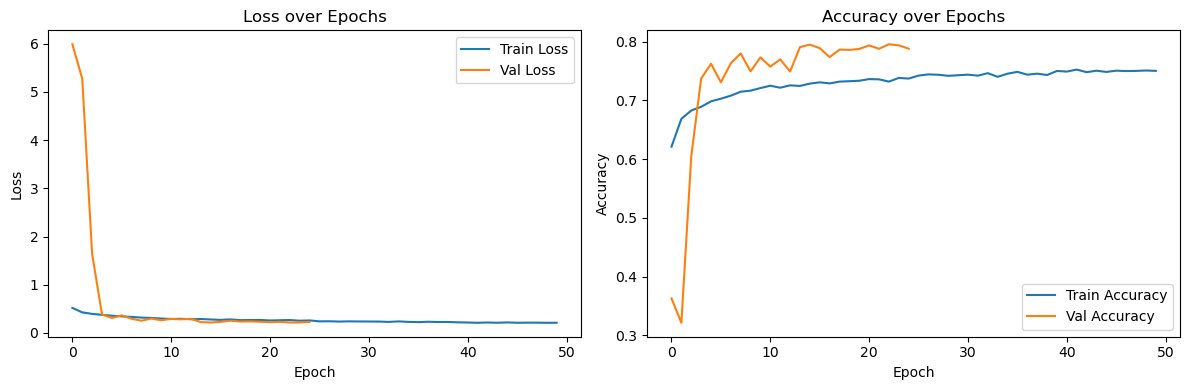

In [34]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # If metrics like IoU or accuracy are used
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


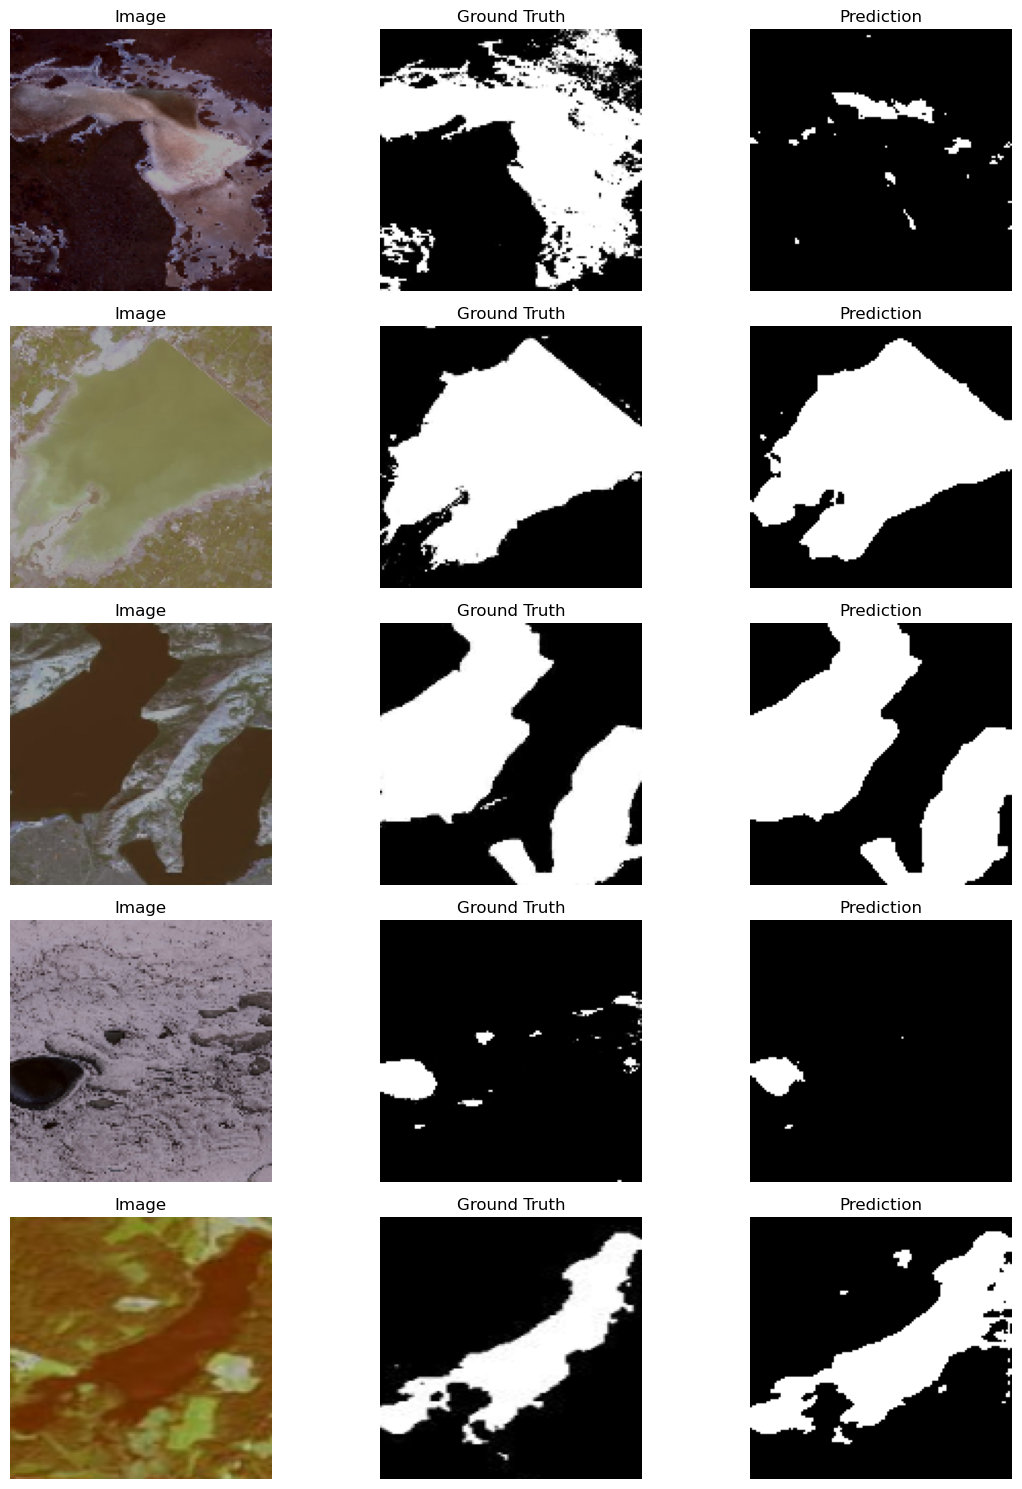

In [35]:
# Predict and visualize results
def visualize_predictions(model, x_val, y_val, num=5):
    preds = model.predict(x_val[:num])

    plt.figure(figsize=(12, num * 3))
    for i in range(num):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(x_val[i])
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(y_val[i], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num, 3, 3*i + 3)
        pred_mask = (preds[i] > 0.5).astype(np.uint8)  # Binary mask
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_val, y_val, num=5)


In [36]:
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

def compute_metrics(model, x_val, y_val, threshold=0.5):
    y_pred = model.predict(x_val, verbose=1)
    y_pred_binary = (y_pred > threshold).astype(np.uint8).reshape(-1)
    y_true_binary = y_val.astype(np.uint8).reshape(-1)

    # IoU Score (Jaccard Index)
    iou = jaccard_score(y_true_binary, y_pred_binary, average='binary')

    # Dice Coefficient
    intersection = np.sum(y_pred_binary * y_true_binary)
    dice = (2. * intersection) / (np.sum(y_pred_binary) + np.sum(y_true_binary))

    # F1 Score (same as Dice for binary masks)
    f1 = f1_score(y_true_binary, y_pred_binary, average='binary')

    print(f"IoU Score      : {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"F1 Score        : {f1:.4f}")

# Call this function after training
compute_metrics(model, x_val, y_val)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
IoU Score      : 0.7295
Dice Coefficient: 0.8436
F1 Score        : 0.8436


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step


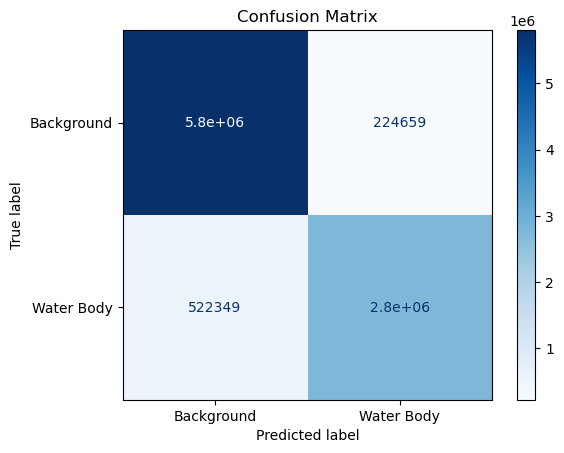

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(np.uint8)

# Threshold the ground truth to binary as well
y_true = (y_val > 0.5).astype(np.uint8)

# Flatten the predictions and ground truths
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Water Body"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
